In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data preprocessing

In [2]:
# get data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# load into dataset
train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


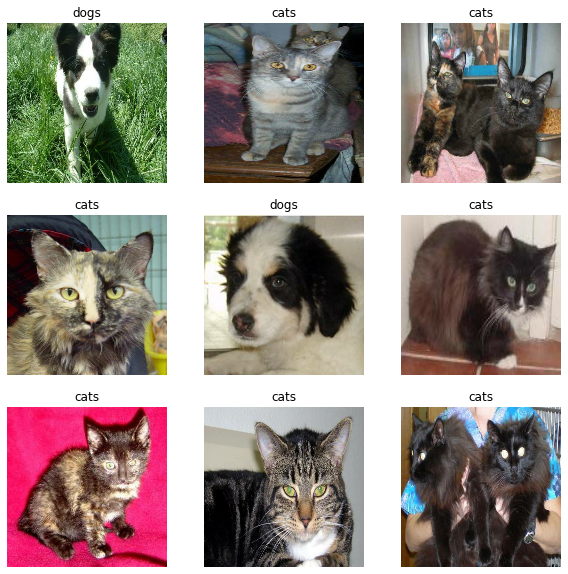

In [4]:
# show some data
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# move 20% of validation set to test set

val_batches = tf.data.experimental.cardinality(validation_dataset) # get the number of batches
test_dataset = validation_dataset.take(val_batches // 5) # take 20%
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
# configure dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

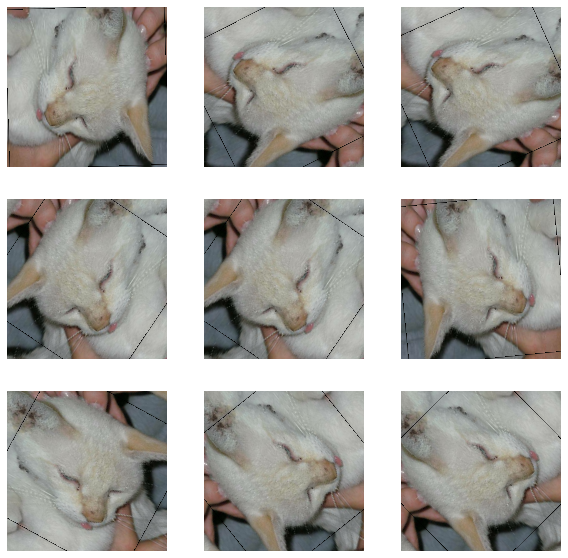

In [7]:
# add data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# look at some augmented data
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
# rescale pixel value into MobileNetV2 which is [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Build base model

In [9]:
# create base model from pre-trained MobileNetV2
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # dont include the top classification layer
                                               weights='imagenet' # use pre-trained weights
                                               )

In [10]:
# the base model converts a batch of (160, 160, 3) images to (5, 5, 1280) features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

# Feature extraction

In [11]:
# freeze the base model
base_model.trainable = False

In [12]:
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

### add the classification layers

In [13]:
# first add a average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [14]:
# then add a dense layer for prediction
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

In [15]:
# add data augmentation, preprocessing, base model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # set training to false because of batch normalization layer
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### train

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [18]:
# training weights and biases
len(model.trainable_variables)

2

In [19]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 6s 94ms/step - loss: 0.6867 - accuracy: 0.5920 - val_loss: 0.5087 - val_accuracy: 0.7562
Epoch 2/10
63/63 [==============================] - 4s 71ms/step - loss: 0.5149 - accuracy: 0.7240 - val_loss: 0.3807 - val_accuracy: 0.8502
Epoch 3/10
63/63 [==============================] - 4s 70ms/step - loss: 0.4162 - accuracy: 0.7900 - val_loss: 0.2955 - val_accuracy: 0.8985
Epoch 4/10
63/63 [==============================] - 4s 69ms/step - loss: 0.3533 - accuracy: 0.8300 - val_loss: 0.2427 - val_accuracy: 0.9208
Epoch 5/10
63/63 [==============================] - 5s 72ms/step - loss: 0.3072 - accuracy: 0.8565 - val_loss: 0.2107 - val_accuracy: 0.9257
Epoch 6/10
63/63 [==============================] - 4s 69ms/step - loss: 0.2807 - accuracy: 0.8735 - val_loss: 0.1893 - val_accuracy: 0.9319
Epoch 7/10
63/63 [==============================] - 4s 70ms/step - loss: 0.2564 - accuracy: 0.8855 - val_loss: 0.1640 - val_accuracy: 0.9455
Epoch 8/10
63

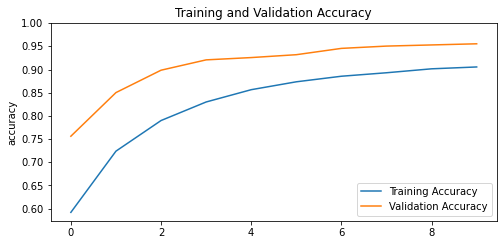

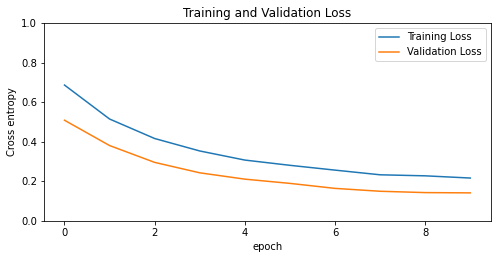

In [20]:
# look at learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

# validation is more accurate for the following reasons
# batch normalization and dropout layers are used in training but not in val
# training metrics is the average of each epoch, while val is after each epoch

# Fine tuning

In [21]:
# only unfreeze the pre-trained model layers after we have trained the new classifier layer
base_model.trainable = True

# check how many layers are in the base model
print('Number of layers in base model: ', len(base_model.layers))

# fine tune from this layer onwards
fine_tune_at = 100

# freeze all layers before that layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in base model:  155


In [22]:
# compile model
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), # use a lower learning rate because training large model while readapting pretraine weights
              metrics=['accuracy']
              )

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [23]:
len(model.trainable_variables)

58

In [24]:
fine_tune_epochs = 10

total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 8s 125ms/step - loss: 0.1627 - accuracy: 0.9290 - val_loss: 0.0674 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 6s 99ms/step - loss: 0.1303 - accuracy: 0.9485 - val_loss: 0.0568 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 6s 98ms/step - loss: 0.1116 - accuracy: 0.9565 - val_loss: 0.0517 - val_accuracy: 0.9876
Epoch 13/20
63/63 [==============================] - 6s 97ms/step - loss: 0.0895 - accuracy: 0.9615 - val_loss: 0.0505 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 6s 96ms/step - loss: 0.0859 - accuracy: 0.9670 - val_loss: 0.0443 - val_accuracy: 0.9889
Epoch 15/20
63/63 [==============================] - 6s 101ms/step - loss: 0.0844 - accuracy: 0.9660 - val_loss: 0.0488 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 6s 97ms/step - loss: 0.0814 - accuracy: 0.9685 - val_loss: 0.0382 - val_accuracy: 0.9864
Epoc

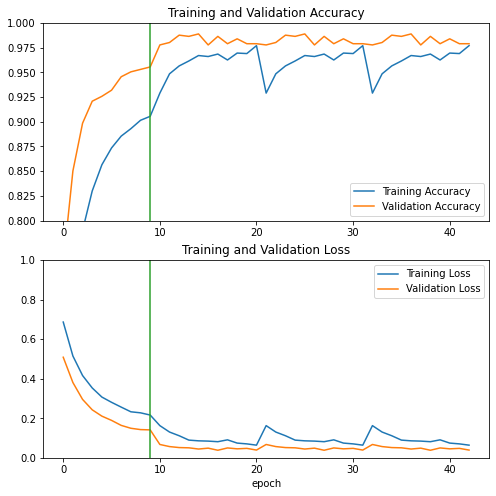

In [27]:
# look at learning curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start fine tuning')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start fine tuning')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

In [28]:
# eval
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy: ', accuracy)

6/6 [==============================] - 0s 40ms/step - loss: 0.0267 - accuracy: 0.9896
Test accuracy:  0.9895833134651184


Predictions:  [1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0]
Labels:  [1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0]


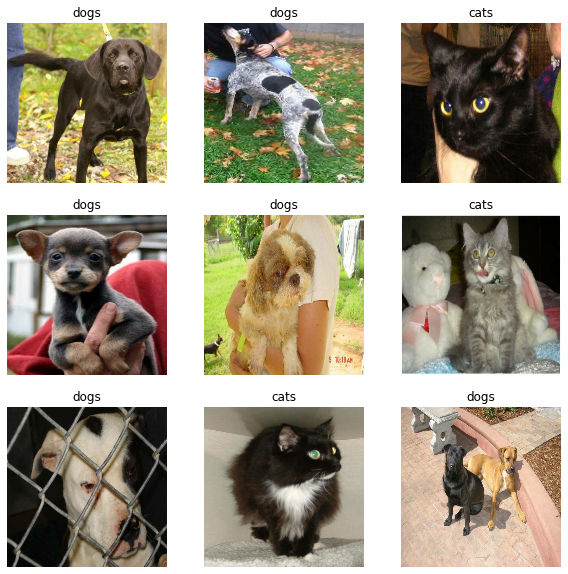

In [29]:
# predict

# get a batch of images
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch).flatten()

# add sigmoid since model returns logtis
predictions = tf.nn.sigmoid(predictions)

# binary classification
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions: ', predictions.numpy())
print('Labels: ', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis('off')